In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

## **First Look at Data**
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary. 

1. **Numerical/Continuous Features**:  
    - price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    - shipping cost    
    
2. **Categorical Features**: 
    - shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    - item_condition_id: The condition of the items provided by the seller
    - name: The item's name
    - brand_name: The item's producer brand name
    - category_name: The item's single or multiple categories that are separated by "\" 
    - item_description: A short description on the item that may include removed words, flagged by [rm]

In [5]:
PATH = "./data/"

In [64]:
train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

In [ ]:
# size of training and dataset
print(train.shape)
print(test.shape)

In [ ]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

In [ ]:
train.head()

### **Price** - Target Variable

The next standard check is with our response or target variables, which in this case is the `price` we are suggesting to the Mercari's marketplace sellers.  The median price of all the items in the training is about \$267 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [ ]:
train.price.describe()

In [ ]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

### **Shipping**

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [ ]:
train.shipping.value_counts()/len(train)

In [ ]:
prc_shipBySeller = train.loc[train.shipping==0, 'price']
prc_shipByBuyer = train.loc[train.shipping==1, 'price']

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

### **Item Category**

There are about **1,287** unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the `brand_name` column will impact the model's prediction. 

In [ ]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

In [ ]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts().head()

In [ ]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

In [ ]:
# reference: https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [ ]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

In [ ]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [ ]:
print("There are %d unique first sub-categories and %d second sub-categories." % \
      (train['subcat_1'].nunique(), train['subcat_2'].nunique()))

Overall, we have  **7 main categories** (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics. 

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x="general_cat", data=train, 
                   order=train['general_cat'].value_counts().index)
plt.title('Number of Items by General Category',fontsize=20)
plt.xlabel('general category', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=17)
plt.xticks(rotation=90)
n = len(train)
for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/n), (x.mean(), y), 
                ha='center', va='bottom', fontsize=17)
plt.show()

In [ ]:
# x = train['general_cat'].value_counts().index.values.astype('str')
# y = train['general_cat'].value_counts().values
# pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

# trace1 = go.Bar(x=x, y=y, text=pct)
# layout = dict(title= 'Number of Items by Main Category',
#               yaxis = dict(title='Count'),
#               xaxis = dict(title='Category'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)

In [ ]:
# x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
# y = train['subcat_2'].value_counts().values[:15]
# pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

# trace1 = go.Bar(x=x, y=y, text=pct,
#                 marker=dict(
#                 color = y,colorscale='Portland',showscale=True,
#                 reversescale = False
#                 ))
# layout = dict(title= 'Number of Items by SubCategory (Top 15)',
#               yaxis = dict(title='Count'),
#               xaxis = dict(title='SubCategory'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)

From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point 

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x="general_cat", y=np.log(train.price+1), data=train, linewidth=2.5, 
           order=train['general_cat'].value_counts().index)
plt.title('Prices by General Category',fontsize=20)
plt.xlabel('general category', fontsize=17)
plt.ylabel('log(price)', fontsize=17)
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [ ]:
# x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

# data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

# layout = dict(title="Price Distribution by General Category",
#               yaxis = dict(title='Frequency'),
#               xaxis = dict(title='Category'))
# fig = dict(data=data, layout=layout)
# py.iplot(fig)

### **Brand Name**

In [ ]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

In [ ]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [ ]:
# trace1 = go.Bar(x=x, y=y, 
#                 marker=dict(
#                 color = y,colorscale='Portland',showscale=True,
#                 reversescale = False
#                 ))
# layout = dict(title= 'Top 10 Brand by Number of Items',
#               yaxis = dict(title='Brand Name'),
#               xaxis = dict(title='Count'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)

### **Item Description**

It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price? We will strip out all punctuations, remove some english stop words (i.e. redundant words such as "a", "the", etc.) and any other words with a length less than 3: 

In [ ]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [ ]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [ ]:
train.head()

In [ ]:
df = train.groupby('desc_len')['price'].mean().reset_index()

In [ ]:
# trace1 = go.Scatter(
#     x = df['desc_len'],
#     y = np.log(df['price']+1),
#     mode = 'lines+markers',
#     name = 'lines+markers'
# )
# layout = dict(title= 'Average Log(Price) by Description Length',
#               yaxis = dict(title='Average Log(Price)'),
#               xaxis = dict(title='Description Length'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)

We also need to check if there are any missing values in the item description (4 observations don't have a description) andl remove those observations from our training set.

In [ ]:
train.item_description.isnull().sum()

In [ ]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

## Text Processing

### **Text processing : tokenization**

Let's do some basic text-preprocessing and normalization and see what are the most common words in the item's description. By tokenizing, we are: 
 - break the descriptions into sentences and then break the sentences into tokens
 - remove punctuation and stop words
 - lowercase the tokens


In [ ]:
# def tokenize(text):
#      # convert to lower case and strip regex
#     text = text.lower()
#     regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
#     txt = regex.sub(" ", text)
#     # tokenize
#     words = nltk.word_tokenize(txt)
#     # remove words in stop words
#     words = [w for w in words \
#             if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
#     return words

In [3]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text)
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [ ]:
#train.drop(['tokens'], axis=1, inplace=True)
#test.drop(['tokens'], axis=1, inplace=True)

In [ ]:
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train['tokens']=train['tokens'].astype(dtype='O')
test['tokens']=test['tokens'].astype(dtype='O')

In [ ]:
train.to_pickle(f'{PATH}train.pickle')
test.to_pickle(f'{PATH}test.pickle')

In [6]:
train = pd.read_pickle(f'{PATH}train.pickle')
test = pd.read_pickle(f'{PATH}test.pickle')

Now that all the descriptions are tokenzied through all the rows, the result is added to the column `tokens` of each item. Let's check what the the tokens looks like for the first few rows:

In [69]:
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description', 'yet']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 

In [70]:
def top10_words(cat):
    tokens = train[train['general_cat']==cat]['tokens']
    alltokens = []
    for t in tokens: alltokens+=t
    return Counter(alltokens).most_common(10)

In [103]:
# for cat in ['Women', 'Men', 'Kids', 'Electronics', 'Beauty']:
#     print('category :', cat)
#     print('top 10 keywords:', top10_words(cat))
#     print('---')

In [107]:
def plot_top10(lst, cat, col):
    plt.bar(range(len(lst)), [val[1] for val in lst], align='center', color=col)
    plt.xticks(range(len(lst)), [val[0] for val in lst])
    plt.ylabel('frequency', fontsize=17)
    plt.tick_params(labelsize=14)
    plt.title('Word Frequency in %s Category' % cat, fontsize=17)

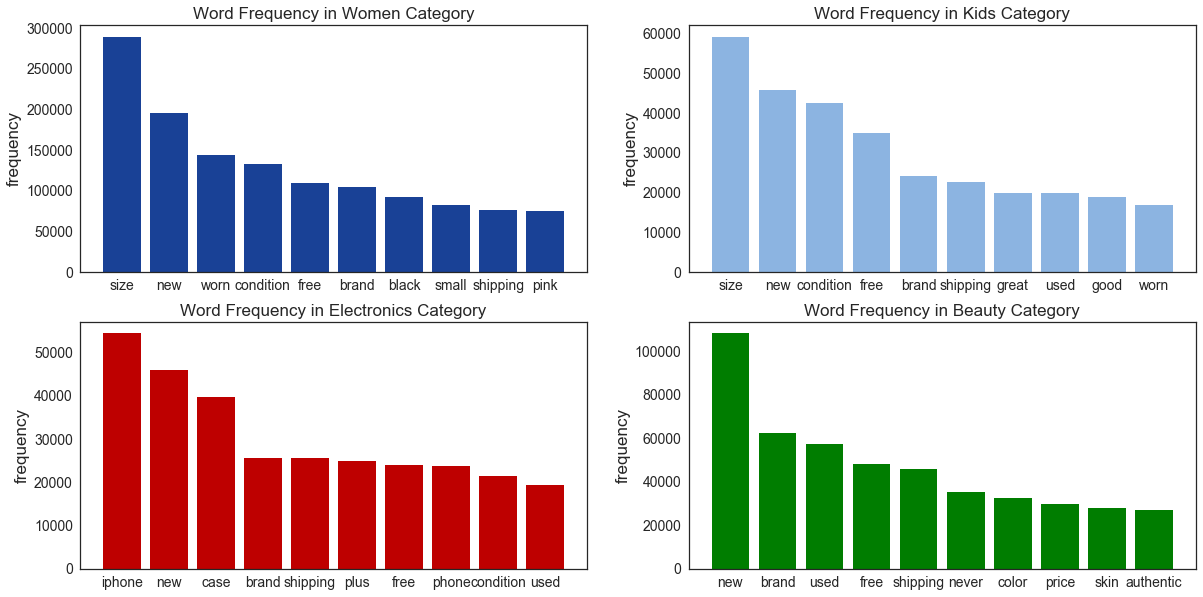

In [111]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plot_top10(top10_words('Women'), 'Women', '#194196')
plt.subplot(222)
plot_top10(top10_words('Kids'), 'Kids', '#8cb4e1')
plt.subplot(223)
plot_top10(top10_words('Electronics'), 'Electronics', '#be0000')
plt.subplot(224)
plot_top10(top10_words('Beauty'), 'Beauty', '#007d00')

### Text processing : tf-idf

tf-idf is the acronym for **Term Frequency–inverse Document Frequency**. It quantifies the importance of a particular word in relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors: 
- **Term Frequency**: the occurences of a word in a given document (i.e. bag of words)
- **Inverse Document Frequency**: the reciprocal number of times a word occurs in a corpus of documents

Think about of it this way: If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. So the second term could be seen as a penalty term that penalizes common words such as "a", "the", "and", etc. tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.

In [ ]:
all_desc = np.append(train['item_description'].values, test['item_description'].values)
#combined_desc = train['item_description'].append(test['item_description'], ignore_index=True)
#combined_cat = train['general_cat'].append(test['general_cat'],ignore_index=True)
#combined_tokens = train['tokens'].append(test['tokens'],ignore_index=True)

In [ ]:
#len(set(all_desc))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, ))
vz = vectorizer.fit_transform(list(all_desc))

In [ ]:
pickle.dump(vectorizer, open("tfidf-vectorizer.pickle", "wb"))
pickle.dump(vz, open("tfidf-vz.pickle", "wb"))

In [11]:
vectorizer = pickle.load(open("tfidf-vectorizer.pickle", "rb"))
vz = pickle.load(open("tfidf-vz.pickle", "rb"))

In [ ]:
vz.shape

vz is a tfidf matrix where: 
- the number of rows is the total number of descriptions
- the number of columns is the total number of unique tokens across the descriptions

In [ ]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Let's look at the distribution of the tfidf scores below: 

In [ ]:
tfidf['tfidf'].hist(bins=50, figsize=(20,10))
plt.title('tf-idf Score Distribution',fontsize=20)
plt.xlabel('tf-idf Score', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.tick_params(labelsize=17)

Below is the 10 tokens with the lowest tfidf score, which is unsurprisingly, very generic words that we could not use to distinguish one description from another. 

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3. 

### _**t-Distributed Stochastic Neighbor Embedding** (t-SNE)_

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

In [12]:
trn = train.copy()
tst = test.copy()
trn['is_test'] = 1
test['is_test'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, test])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [14]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [15]:
svd_tfidf.shape

(15000, 30)

In [46]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=2, random_state=42, n_iter=500)

In [ ]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

In [ ]:
tsne_tfidf.shape

In [ ]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
combined_sample.reset_index(inplace=True, drop=True)

In [ ]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

In [ ]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

## Clustering

### KMeans

In [ ]:
vz.shape

""This matrix can be seen as a collection of (x) high-dimensional vectors (y). Some algorithms like K-means can crunch this data structure and produce blocks of similar or "close" data points based on some similarity measure like the euclidean distance.

One thing to know about Kmeans is that it needs the number of clusters up front. This number is usually found by trying different values until the result looks satisfactory:

In [60]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [61]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

Let's look at the main keywords that describe each clusters: 

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(num_clusters-20):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

In order to plot these clusters, first we will need to reduce the dimension of the distances to 2 using tsne: 

In [62]:
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)

In [63]:
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.107s...
[t-SNE] Computed neighbors for 15000 samples in 10.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sa

In [64]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [73]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']

In [66]:
clusters = np.unique(kmeans_clusters) 
cmap = dict()
for i,cluster in enumerate(clusters): 
    cmap[str(cluster)] = colormap[i]

In [67]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [91]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'], color=colormap[kmeans_clusters],
                                    clusters=kmeans_df['cluster']
                                     description=kmeans_df['description'],
                                     category=kmeans_df['category']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

""At first sight you could notice that they deal approximately with the same topic. This is coherent since we build our clusters using similarities between relevant keywords.

We can also notice that within the same cluster, many subclusters are isolated from one another. This gives an idea about the global topic.

Kmeans separates the documents into disjoint clusters. the assumption is that each cluster is attributed a single topic. However, descriptions may in reality be characterized by a "mixture" of topics. We'll cover how to deal with this problem with the LDA algorithm.""

### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is an algorithms used to discover the topics that are present in a corpus. LDA is based on probabilistic graphical modelling and it is capable of returning the documents that belong to a topic in a corpus and the words that belong to a topic.

Its input is a **bag of words**, i.e. each document represented as a row, with each columns containing the count of words in the corpus

*Reference: https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730*

In [8]:
import lda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [13]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [40]:
lda_model = LatentDirichletAllocation(n_components=20,
                                max_iter=20,
                                learning_method='online',
                                random_state=42,
                                verbose=1)
#lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
#X_topics = lda_model.fit_transform(cvz)

In [41]:
X_topics = lda_model.fit_transform(cvz)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


In [42]:
n_top_words = 8
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: size small pink secret victoria victoria secret size small dress
Topic 1: little without lip bought jacket matte lipstick would
Topic 2: bag body inches leather bottom pocket made zipper
Topic 3: price please firm price firm ship shipping free purchase
Topic 4: new brand brand new tags new tags color two full
Topic 5: watch phone screen charger cable battery ipad steel
Topic 6: back size shirt front love long sleeve pockets
Topic 7: large bundle size large save bundle save black save shipping comes
Topic 8: new brand brand new never worn never worn size new never
Topic 9: free home smoke free home smoke free pet pet free lularoe
Topic 10: super skin cute super cute use face nice read
Topic 11: condition great used worn size great condition like like new
Topic 12: brush hair first shipped may care need days
Topic 13: size fits silver material tag high men soft
Topic 14: shipping free free shipping items new bundle day make
Topic 15: box original shape still good urban gold left

In [47]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.023s...
[t-SNE] Computed neighbors for 15000 samples in 6.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

In [43]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)
#doc_topic = lda_model.doc_topic_
lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

In [51]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [53]:
combined_sample.reset_index(drop=True, inplace=True)

In [54]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [57]:
keys = np.unique(lda_df['topic'].values)
cmap = dict()
for i,k in enumerate(keys): 
    cmap[k] = colormap[i]
    
colors = [cmap[x] for x in lda_df['topic']]

In [92]:
from bokeh.models import ColumnDataSource, CDSView
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'], color=colormap[lda_keys],
                                     description=lda_df['description'],
                                     topic=lda_df['topic'],
                                     category=lda_df['category']))

plot_lda.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
show(plot_lda)

### Visualization of the LDA topics using pyLDAvis

In [52]:
lda_df['len_docs'] = combined_sample['tokens'].map(len)

In [53]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [54]:
ldadata = prepareLDAData()

In [56]:
import pyLDAvis
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)

/Users/ThyKhueLy/anaconda2/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [58]:
pyLDAvis.save_html(prepared_data,'./pyldadavis.html')

## Conclusion

- applied tf-idf statistics as a natural language preprocessing technique
- created clusters on top of the tf-idf matrix using the KMeans algorithm and visualized them using Bokeh
- extracted topics using the Latent Dirichlet Allocation algorithm and visualized them using Bokeh and pyldavis